# Lab 3 - Query Expansion

In [1]:
import sys
sys.path.append('../..')

from helper_utils_02 import load_pdf_chroma, word_wrap, project_embeddings
from chromadb import Client
# from chromadb.config import Settings
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

from py3810.myUtils import pickle_dump, pickle_load

import chromadb
import umap.umap_ as umap

In [2]:
# Specify the directory to store the database files
path_chromadb_dump = '../Chromadb/'
persist_dir = '../Chromadb/collections'
is_persistent = False

filename_pdf = 'microsoft_annual_report_2022.pdf'
collection_name = 'microsoft_annual_report_2022'
embedding_function = SentenceTransformerEmbeddingFunction()

In [67]:
if is_persistent:
  try:
    embeddings = pickle_load(filename_pickle='_embeddings', path_pickle_dump=path_chromadb_dump)
    umap_transform = pickle_load(filename_pickle='_umap_transform', path_pickle_dump=path_chromadb_dump)
    projected_dataset_embeddings = pickle_load(filename_pickle='_projected_dataset_embeddings', path_pickle_dump=path_chromadb_dump)
    print(f'loaded embeddings, umpa_transform, projected_dataset_embeddings')
  except FileNotFoundError:
    chroma_collection = \
      load_pdf_chroma(
        filename_pdf=filename_pdf,
        collection_name=collection_name,
        embedding_function=embedding_function,
        persist_directory=persist_dir,
        is_persistent=is_persistent,
      )
    print(f'Created chroma_collection {collection_name}')
    print(f'chroma_collection.count(): {chroma_collection.count()}')
    embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
    umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)
    projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)
    print(f'created embeddings, umpa_transform, projected_dataset_embeddings')
    pickle_dump(file_to_pickle=embeddings, filename_pickle='_embeddings', path_pickle_dump=path_chromadb_dump)
    pickle_dump(file_to_pickle=umap_transform, filename_pickle='_umap_transform', path_pickle_dump=path_chromadb_dump)
    pickle_dump(file_to_pickle=projected_dataset_embeddings, filename_pickle='_projected_dataset_embeddings', path_pickle_dump=path_chromadb_dump)    
    print(f'saved embeddings, umpa_transform, projected_dataset_embeddings')
else:
  client = chromadb.PersistentClient(path=persist_dir)
  chroma_collection = client.get_collection(name=collection_name, embedding_function=embedding_function)
  print(f'Loaded chroma_collection {collection_name}')
  embeddings = pickle_load(filename_pickle='_embeddings', path_pickle_dump=path_chromadb_dump)
  umap_transform = pickle_load(filename_pickle='_umap_transform', path_pickle_dump=path_chromadb_dump)
  projected_dataset_embeddings = pickle_load(filename_pickle='_projected_dataset_embeddings', path_pickle_dump=path_chromadb_dump)
  print(f'loaded embeddings, umpa_transform, projected_dataset_embeddings')
  print(f'chroma_collection.count(): {chroma_collection.count()}')  

Loaded chroma_collection microsoft_annual_report_2022
loaded embeddings, umpa_transform, projected_dataset_embeddings
chroma_collection.count(): 349


#### Chroma Usage Guide
https://docs.trychroma.com/guides

In [4]:
import os
import openai
# import sys
# sys.path.append('../..')
from openai import OpenAI

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv('.env\my_api_key.env')) # read local .env file
openai.api_key = os.environ['OPENAI_API_KEY']

openai_client = OpenAI()

Don't run next cell if embeddings, umap_transform, projected_dataset_embeddings are loaded

## Expansion with generated answers

https://arxiv.org/abs/2305.03653

In [5]:
def augment_query_generated(query, model="gpt-3.5-turbo"):
    messages = [
        {
            "role": "system",
            "content": "You are a helpful expert financial research assistant. Provide an example answer to the given question, that might be found in a document like an annual report. "
        },
        {"role": "user", "content": query}
    ] 

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    return content

In [19]:
original_query = "Was there significant turnover in the executive team?"
hypothetical_answer = augment_query_generated(original_query)

joint_query = f"{original_query} {hypothetical_answer}"
print(word_wrap(joint_query))

Was there significant turnover in the executive team? In the past
fiscal year, there was one noteworthy change within the executive team.
Our former Chief Financial Officer, Mr. John Smith, retired after 15
years of dedicated service to the company. Following a thorough search
process, we are pleased to announce the appointment of Ms. Emily
Johnson as the new CFO. Ms. Johnson brings with her a wealth of
experience in financial management and strategic planning, and we are
confident in her ability to lead our finance team effectively.


In [29]:
results['embeddings']

[[[-0.015601041726768017,
   0.0002661342441570014,
   0.03910122066736221,
   -0.057808566838502884,
   0.02359718829393387,
   0.03126533702015877,
   0.08253506571054459,
   0.07091999053955078,
   -0.03467073291540146,
   0.02551076002418995,
   0.055217381566762924,
   0.02286255732178688,
   0.028551863506436348,
   0.004140306729823351,
   0.0437764935195446,
   0.017663080245256424,
   0.03504554554820061,
   0.033747598528862,
   -0.03852662071585655,
   -0.007684843149036169,
   0.0702882707118988,
   0.0026649467181414366,
   -0.009965025819838047,
   -0.06176968663930893,
   0.06872371584177017,
   -0.10945825278759003,
   -0.006409022957086563,
   -0.02426757663488388,
   -0.022126754745841026,
   -0.048099957406520844,
   -0.042944807559251785,
   0.05921642854809761,
   -0.07110298424959183,
   0.021575037389993668,
   -0.04894491657614708,
   -0.05714757367968559,
   -0.02124660275876522,
   0.06706315279006958,
   0.046331390738487244,
   -0.08263516426086426,
   0.066

In [68]:
chroma_collection.count()

349

In [70]:
vector_dim = len(results['embeddings'][0][0])
query_results = len(results['embeddings'][0])
print(f'vector_dim: {vector_dim}')
print(f'query_results: {query_results}')

vector_dim: 384
query_results: 5


In [71]:
results = chroma_collection.query(query_texts=joint_query, n_results=5, include=['documents', 'embeddings'])
retrieved_documents = results['documents'][0]
vector_dim = len(results['embeddings'][0][0])
query_results = len(results['embeddings'][0])
print(f'vector_dim: {vector_dim}')
print(f'query_results: {query_results}')

for doc in retrieved_documents:
  print(word_wrap(doc))
  print('')

vector_dim: 384
query_results: 5
89 directors and executive officers of microsoft corporation directors
satya nadella chairman and chief executive officer, microsoft
corporation sandra e. peterson 2, 3 operating partner, clayton,
dubilier & rice, llc john w. stanton 1, 4 founder and chairman, trilogy
partnerships reid g. hoffman 4 general partner, greylock partners penny
s. pritzker 4 founder and chairman, psp partners, llc john w. thompson
3, 4 lead independent director, microsoft corporation hugh f. johnston
1 vice chairman and executive vice president and chief financial
officer, pepsico, inc. carlos a. rodriguez 1 chief executive officer,
adp, inc. emma n. walmsley 2, 4 chief executive officer, gsk, plc teri
l. list 1, 3 former executive vice president and chief financial
officer, gap, inc. charles w. scharf 2, 3 chief executive officer and
president, wells fargo & company padmasree warrior 2 founder, president
and chief executive

the company engaged deloitte & touche llp, an inde

In [8]:
len(results['embeddings'][0][0])

384

In [9]:
retrieved_embeddings = results['embeddings'][0]
original_query_embedding = embedding_function([original_query])
augmented_query_embedding = embedding_function([joint_query])

projected_original_query_embedding = project_embeddings(original_query_embedding, umap_transform)
projected_augmented_query_embedding = project_embeddings(augmented_query_embedding, umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


(-0.4267502035945654,
 10.904596148058772,
 5.316428327560425,
 11.376193857192993)

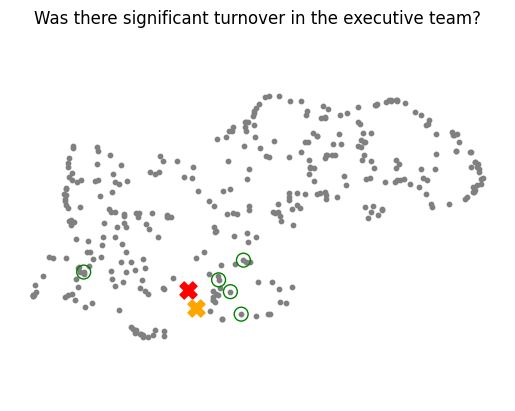

In [10]:
import matplotlib.pyplot as plt

# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(projected_original_query_embedding[:, 0], projected_original_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_augmented_query_embedding[:, 0], projected_augmented_query_embedding[:, 1], s=150, marker='X', color='orange')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')

## Expansion with multiple queries


In [11]:
def augment_multiple_query(query, model="gpt-3.5-turbo"):
    messages = [
        {
            "role": "system",
            "content": "You are a helpful expert financial research assistant. Your users are asking questions about an annual report. "
            "Suggest up to five additional related questions to help them find the information they need, for the provided question. "
            "Suggest only short questions without compound sentences. Suggest a variety of questions that cover different aspects of the topic."
            "Make sure they are complete questions, and that they are related to the original question."
            "Output one question per line. Do not number the questions."
        },
        {"role": "user", "content": query}
    ]

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    content = content.split("\n")
    return content

In [12]:
original_query = "What were the most important factors that contributed to increases in revenue?"
augmented_queries = augment_multiple_query(original_query)

for query in augmented_queries:
    print(query)

What were the costs associated with generating the revenue?  
How did the company allocate its resources to drive revenue growth?  
What were the main sources of revenue for the company?  
Did the company implement any new strategies to boost revenue?  
Were there any significant changes in the market that impacted revenue generation?


In [13]:
queries = [original_query] + augmented_queries
results = chroma_collection.query(query_texts=queries, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents']

# Deduplicate the retrieved documents
unique_documents = set()
for documents in retrieved_documents:
    for document in documents:
        unique_documents.add(document)

for i, documents in enumerate(retrieved_documents):
    print(f"Query: {queries[i]}")
    print('')
    print("Results:")
    for doc in documents:
        print(word_wrap(doc))
        print('')
    print('-'*100)

Query: What were the most important factors that contributed to increases in revenue?

Results:
engineering, gaming, and linkedin. • sales and marketing expenses
increased $ 1. 7 billion or 8 % driven by investments in commercial
sales and linkedin. sales and marketing included a favorable foreign
currency impact of 2 %. • general and administrative expenses increased
$ 793 million or 16 % driven by investments in corporate functions.
operating income increased $ 13. 5 billion or 19 % driven by growth
across each of our segments. current year net income and diluted eps
were positively impacted by the net tax benefit related to the transfer
of intangible properties, which resulted in an increase to net income
and diluted eps of $ 3. 3 billion and $ 0. 44, respectively. prior year
net income and diluted eps were positively impacted by the net tax
benefit related to the india supreme court decision on withholding
taxes, which resulted in an increase to net income and diluted eps of $
620 

In [14]:
original_query_embedding = embedding_function([original_query])
augmented_query_embeddings = embedding_function(augmented_queries)

project_original_query = project_embeddings(original_query_embedding, umap_transform)
project_augmented_queries = project_embeddings(augmented_query_embeddings, umap_transform)


100%|██████████| 5/5 [00:14<00:00,  2.92s/it]


In [15]:
result_embeddings = results['embeddings']
result_embeddings = [item for sublist in result_embeddings for item in sublist]
projected_result_embeddings = project_embeddings(result_embeddings, umap_transform)


100%|██████████| 30/30 [01:19<00:00,  2.64s/it]


(-0.4267502035945654,
 10.904596148058772,
 5.316428327560425,
 11.376193857192993)

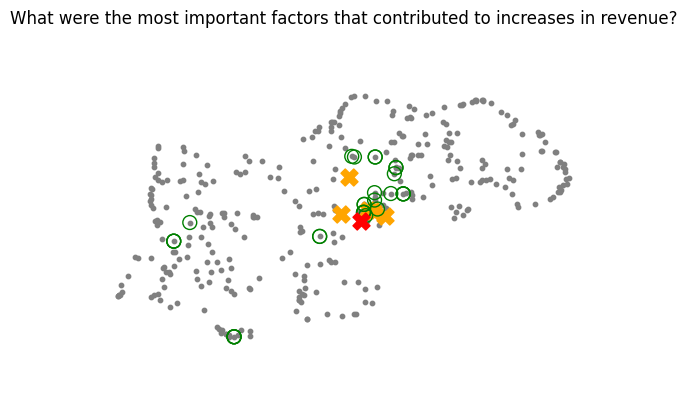

In [16]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(project_augmented_queries[:, 0], project_augmented_queries[:, 1], s=150, marker='X', color='orange')
plt.scatter(projected_result_embeddings[:, 0], projected_result_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(project_original_query[:, 0], project_original_query[:, 1], s=150, marker='X', color='r')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')